Group Project Report : Heart Disease
-

Introduction:
As of 2020, heart disease was one of the most leading factors contributing to death worldwide. The most common cause of heart disease is a buildup of fatty plaques in the arteries. Risk factors for heart disease include a poor diet, lack of exercise, obesity, and smoking. Symptoms of heart disease include rapid heart rate, chest pain, and shortness of breath. Gaining an acuurate and useful diagnosis from a doctor can be quite tedious and time consuming. A digital classifier could help speed up the process of diagnosis and decrease possible risks to health. 

The question we will be adressing is; Can you use Age and Maximum Heart Rate Achieved to accuratly predict the presence of heart disease? 

The data set that will be used is "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data" and it contains 14 attributes which state the quantitative variables that are of interest in regard to heart disease factors: 
- 1. age: age in years
- 2. sex: sex (1 = male; 0 = female)
- 3. cp: chest pain type 
- 4. trestbps: resting blood pressure (in mm Hg)
- 5. chol: serum cholestoral in mg/dl
- 6. fbs: (fasting blood sugar > 120 mg/dl)
- 7. restecg: resting electrocardiographic results
- 8. thalach: maximum heart rate achieved
- 9. exang: exercise induced angina
- 10. oldpeak = ST depression induced by exercise relative to rest
- 11. slope: the slope of the peak exercise ST segment
- 12. ca: number of major vessels (0-3) colored by flourosopy
- 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- 14. num: diagnosis of heart disease (angiographic disease status)

Methods and Results 
-

First, we are loading in all of the packages needed to run the functions used to make our classifier into our library.

We have also used the `option()` function to only show the first 6 and last 6 rows of our dataset at a time.

In [7]:
# import libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Next, we loaded the file, `https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data`, from the URL into R using the function `read_delim()`.

Then we had to tidy the data because it did not contain column names and rows containing `?` instead of data had to be removed from the data set.

We used the `rename()` function to set each of the 14 atributues in the data set to their corresponding names.

Ex: age = X1.

In [3]:
heart_disease <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
                    rename(age =X1,
                              sex = X2,
                              cp = X3,
                              trestbps = X4,
                              chol = X5,
                              fbs = X6,
                              restecg = X7,
                              thalach = X8, 
                              exang = X9,
                              oldpeak = X10, 
                              slope = X11, 
                              ca = X12, 
                              thal = X13, 
                              num = X14) 

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


By creating a custom function, we are able to set all `?` equal to `NA`, then to remove all of the rows that contain `NA`. After that, all of the data is now organized into the proper columns, correctly titled, and all of the observations contain the correct data. 

In [4]:
remove_qm <- function(x){
    ifelse(as.character(x) == "?", NA, x)
    }

heart_disease_clean <- map_df(heart_disease, remove_qm) |> na.omit()

Next, we wanted to only predicted whether or not the patient will have heart disease, so we used `mutate()` to created a column called `num_edited`, which contained whether a patient had heart disease or not as either "Yes" or "No".

"Yes" being when `num` is equal to 1, 2, 3, or 4 and "No" being when `num` is equal to 0.

Also using `mutate`, we set `num_edited` to be our factor by using the `as_factor()` function. This way we will be able to use `num_edited` as the variable we are classifying patients by.

In [10]:
heart_disease <- heart_disease_clean |> 
    mutate(num_edited = ifelse(num == "0", "No", ifelse(num == 1 | num == 2 | num == 3 | num == 4 , "Yes", NA))) |>
                mutate(num_edited = as_factor(num_edited)) 

We then want verify the levels in our factor `num_edited`. We do so using `pull()` and `levels()` to see the different categories that are in that column.
It returns "Yes" and "No", because those are the variables we set it to in the previous block of code.

Below we use the `group_by()`, `summarize()`, and `n` functions to find the number and percentage of patients with heart disease and without heart disease in our data set.

In [5]:
#summary of the data set 
# makes num the factor by which every predictor is being used to classify

#shows the different categories that heart disease can be classified as
heart_disease |>
    pull(num_edited) |>
    levels()

#Show the percentage of the whole data that each level of severity makes up
num_obs <- nrow(heart_disease)
heart_disease |> 
    group_by(num_edited) |> 
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
        )

[1] "No"  "Yes"

num_edited,count,percentage
<fct>,<int>,<dbl>
No,160,53.87205
Yes,137,46.12795


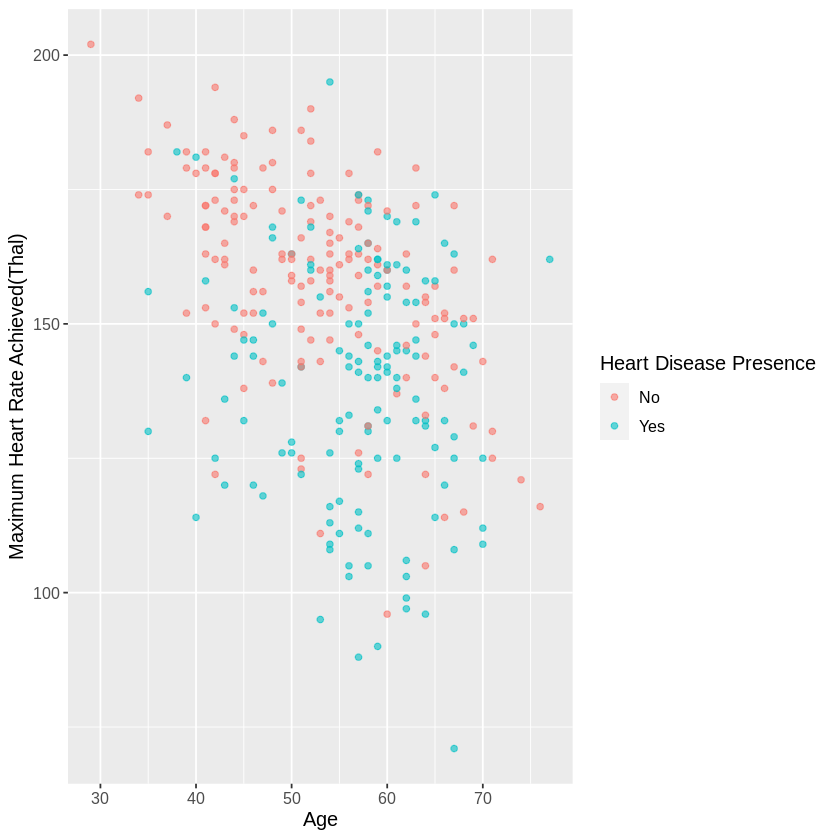

In [10]:
#visualization of the 2 predictors and where each category
# of classified data falls into
age_thal <- heart_disease |> 
    ggplot(aes(x = age, y = thalach, color = num_edited)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age",
         y = "Maximum Heart Rate Achieved(Thal)",
         color = "Heart Disease Presence") +
    theme(text = element_text(size =12))
age_thal

We currently have a single massive data frame that contains all of the information. We wouldn't have any data to use as a gauge of how accurate the model is if we fed all the data into the classifier. The model will recognise the data because it has "seen" it before and will most likely make the right prediction if we use.
As a result, we must determine the model's accuracy based on how well it predicts data that it hasn't "seen" before in order to allow for a fair process of measurement. In order to accomplish this, we can divide the data into training and testing datasets, with our classification model only using the training dataset. The testing dataset that results from this will be a set of data that the model has never seen before. The testing dataset can then be used to gauge how well our model predicts "new" data.

In [6]:
#classifyer
set.seed(1)

heart_disease_split <- initial_split(heart_disease, prop = .75, strata = num_edited)
                        
heart_disease_training <- training(heart_disease_split)
                        
heart_disease_testing <- testing(heart_disease_split)

heart_disease_training

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_edited
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,No
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,No
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2,Yes
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,Yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,Yes


In [7]:
#creating a recipe 
heart_recipe<-recipe(num_edited ~ age +
                     thalach, data=heart_disease_training)|>
#standardizing the data (scaling and centring)
step_scale(all_predictors())|>
step_center(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6029293,5,0.03413723,Preprocessor1_Model01
2,accuracy,binary,0.5983838,5,0.03483289,Preprocessor1_Model02
3,accuracy,binary,0.6080808,5,0.01541770,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.7159596,5,0.02793007,Preprocessor1_Model23
24,accuracy,binary,0.7159596,5,0.02793007,Preprocessor1_Model24
25,accuracy,binary,0.7069697,5,0.02820398,Preprocessor1_Model25


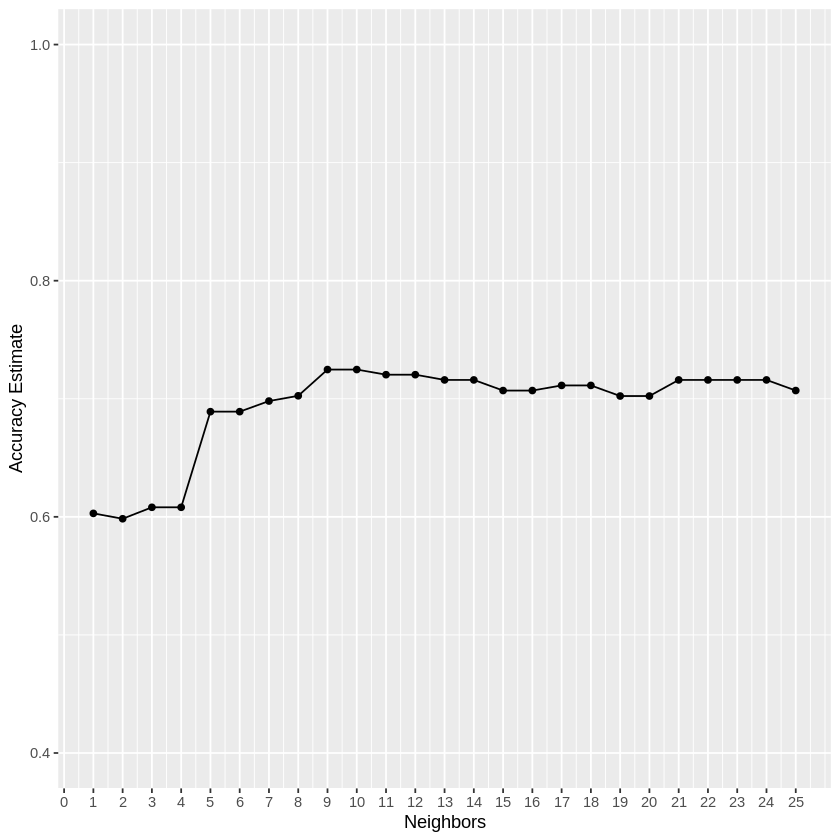

In [36]:
#??
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#??
heart_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num_edited)

#creates tibble for k values
possible_k <- tibble(neighbors = seq(from = 1, to = 25))

#?
knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = possible_k) |>
  collect_metrics() 
#?
accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

#graph results to find the k value that gives the best accuracy
accuracy_versus_k<-ggplot(accuracies, aes (x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x= "Neighbors", y= "Accuracy Estimate")+
scale_x_continuous(breaks=seq(0,25, by=1))+
scale_y_continuous(limits=c(0.4, 1.0))
accuracy_versus_k

In [33]:
#we can infer that k= 16 gives us the greatest accuracy 
knn_spec2<-nearest_neighbor(weight_func="rectangular", neighbors= 8)|>
set_engine("kknn")|>
set_mode("classification")
knn_spec2

heart_fit<-workflow()|>
add_recipe(heart_recipe)|>
add_model(knn_spec2)|>
fit(data=heart_disease_training)
heart_fit

heart_predictions<-predict(heart_fit, heart_disease_testing)|>
bind_cols(heart_disease_testing)
heart_predictions

heart_prediction_accuracy <- heart_predictions |>
                        metrics(truth = num_edited, estimate = .pred_class)
heart_prediction_accuracy

heart_mat <- heart_predictions |>
            conf_mat(truth = num_edited, estimate = .pred_class)
heart_mat

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 8
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(8,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2972973
Best kernel: rectangular
Best k: 8

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_edited
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
No,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,No
Yes,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3,Yes
No,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yes,58,1,4,114,318,0,1,140,0,4.4,3,3.0,6.0,4,Yes
No,44,1,4,120,169,0,0,144,1,2.8,3,0.0,6.0,2,Yes
Yes,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1,Yes


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7200000
kap,binary,0.4344704


          Truth
Prediction No Yes
       No  31  12
       Yes  9  23

Disscussion
-

Summarize what you found
- Discuss whether this is what you expected to find?

Through the use of classification via k nearest neighbours, we have created a model to predict the presence of heart disease with 72% accuracy. Given the dataset, majority of the  predictors that proved to have a strong correlation to the presene of heart disease were categorical values, therefore were unusable in our model. We were forced to use the limited number of predictors with a numeric value, consequently we did not expect a strong accuracy and our model follows that assumption. 
- What impact could such findings have? 

If implemented into the real world, our current model would not prove to be super beneficial to the healcare community. Although majority of the predictions are correct, there is still the significant risk of misdiagnosis. Even one case of misdiagnosis (false negative) could cost someones life, therefore it is imperative that the model is adjusted even more to predict with finer accuracy and precision. Once the accuracy issue is adressed our model could save patient wait times and provide quicker diagnosis, potentially aiding in the health crisis regarding access issues. 

- Discuss what future questions could this lead to?

Our model depicted the relationship between semi-useful predictors and heart disease, this only opens the possibility for more models and predictors to emerge. If age and maximum heart rate achieved (Thalach) did a good job at predicting heart disease, what predictors can do a great job ? Once those are determined, questions regarding the manipulation of those variables may emerge alongside preventative measures. (ex - high cholesterol levels prove to have a strong correlation with heart disease, so we can ask questions about how to lower cholesterol levels in a health way). 

Refrences 
-
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references). (MLA Formatting)
    - “Cardiovascular Diseases (Cvds).” World Health Organization, World Health Organization, https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds). Acessed 23. Nov. 2022
    - Virani, Salim S., et al. “Heart Disease and Stroke Statistics-2021 Update.” Circulation, 27 Jan. 2021, https://www.ahajournals.org/doi/10.1161/CIR.0000000000000950. Acessed 19. Nov. 2022
- Make sure to cite the source of your data as well.
    - UCI Machine Learning Repository: Heart Disease Data Set, https://archive.ics.uci.edu/ml/datasets/Heart%20Disease. Acessed 20. Oct. 2022